# Retrieve the data and create the networks through Reddit's API

In [323]:
# PRAW to interact with reddit
import praw
import networkx as nx
from fa2 import ForceAtlas2  #the package should be installed before
import matplotlib.pyplot as plt
from datetime import datetime
from statistics import mean, median, quantiles
from networkx.algorithms.traversal.breadth_first_search import descendants_at_distance

In [324]:
reddit = praw.Reddit(client_id='kVFSoq-sZG0CJnHjlBxAZA',
                     client_secret='uJREuWTR5I3NYYMh8LgmODjei77IJQ',
                     user_agent='ggg997')

In [325]:
def authors_of(top_level_comment, count_comment=0):
    authori = []
    if len(top_level_comment.replies) == 0:
        count_comment = 0
        return authori
    else:
        for num, comment in enumerate(top_level_comment.replies):
            try:
                count_comment += 1
                print('-' * count_comment, comment.author.name)
                authori.append(comment.author.name)
                authorGraph.add_node(comment.author.name)
                authorGraph.add_edge(comment.author.name, top_level_comment.author.name)
            except:
               continue
            authori.extend(authors_of(comment, count_comment))
            #replies_of(comment, count_comment)
    return authori

In [326]:
def replies_of(top_level_comment, created_utcs, count_comment=0):
    replies = []
    if len(top_level_comment.replies) == 0:
        count_comment = 0
        return replies
    else:
        for num, comment in enumerate(top_level_comment.replies):
            try:
                count_comment += 1
                print('-' * count_comment, comment.id)
                replies.append(comment.id)
                created_utcs.append(comment.created_utc)
                commentsGraph.add_node(comment.id, author = comment.author.name, body = comment.body, created = comment.created_utc)
                commentsGraph.add_edge(top_level_comment.id, comment.id)
            except:
               continue
            replies.extend(replies_of(comment, created_utcs))
            #replies_of(comment, count_comment)
    return replies

In [330]:
def max_depth_and_H_index(G):
    i=0
    descs = [len(descendants_at_distance(G, list(G.nodes())[0], i))]
    while descs[-1] > 0:
        i = i+1
        descs.append(len(descendants_at_distance(G, list(G.nodes())[0], i)))
    
    for j in range(len(descs)):
        if descs[j] < j:
            return i, j

In [334]:
post1 = reddit.submission(id='pq0ndj')
post1.comments.replace_more(limit=None)

[]

In [336]:
created_utcs = [post1.created_utc]
datetime.utcfromtimestamp(post1.created_utc).strftime('%Y-%m-%d %H:%M:%S')

'2021-09-17 13:57:15'

In [338]:
#create the network object
authorGraph = nx.DiGraph()
commentsGraph = nx.DiGraph()

In [339]:
authorGraph.add_node(post1.author.name)
commentsGraph.add_node(post1.id, author = post1.author.name, body = post1.title, created = post1.created_utc)

In [340]:
authors = []
for comment in post1.comments:
    print(comment.author)
    if(comment.author != None):
        authorGraph.add_node(comment.author.name)
        authorGraph.add_edge(comment.author.name, post1.author.name)
        authors.append(comment.author.name)
        authors.extend(authors_of(comment))
    print()
    print(" ------------------------------------------------------------------------------------- ")

AutoModerator

 ------------------------------------------------------------------------------------- 
DustinBraddock

 ------------------------------------------------------------------------------------- 
Atvenice
- ILikeCoins

 ------------------------------------------------------------------------------------- 
thaw4188
- ChestertonsTopiary

 ------------------------------------------------------------------------------------- 
Matir
- CollateralKite
-- Bifobe
--- CollateralKite

 ------------------------------------------------------------------------------------- 


In [341]:
comments = []
max_depth = 1

for comment in post1.comments:
    depth = [1]
    print(comment.id)
    if(comment.id != None):
        created_utcs.append(comment.created_utc)
        commentsGraph.add_node(comment.id, author = comment.author.name, body = comment.body, created = comment.created_utc)
        commentsGraph.add_edge(post1.id, comment.id)
        comments.append(comment.id)
        comments.extend(replies_of(comment,created_utcs))
    print()
    print(" ------------------------------------------------------------------------------------- ")

hd7ho13

 ------------------------------------------------------------------------------------- 
hd8xohp

 ------------------------------------------------------------------------------------- 
hd7i0t6
- hd7tuup

 ------------------------------------------------------------------------------------- 
hdahmwm
- hddvq0z
-- hdaumqb

 ------------------------------------------------------------------------------------- 
hd8cxy9
- hd8qih5
- hd8x4as
- hd8z9t1
-- hdilrq2

 ------------------------------------------------------------------------------------- 


In [343]:
commentsGraph.nodes()["pq0ndj"]

{'author': 'Atvenice',
 'body': 'Bayesian Hypothesis Testing and Hierarchical Modeling of Ivermectin Effectiveness',
 'created': 1631887035.0}

In [314]:
created_utcs1=nx.get_node_attributes(commentsGraph,'created')

In [345]:
created_utcs1=list(nx.get_node_attributes(commentsGraph,'created').values())

lifeTime = max(created_utcs1)-min(created_utcs1)
averageTime = mean(created_utcs1)-min(created_utcs1)
medianTime = median(created_utcs1)-min(created_utcs1)
quantiles95 = quantiles(created_utcs1,n=10)[8]
lifetime95 = quantiles95-min(created_utcs1)

print("lifeTime: ",lifeTime/86400, " days")
print("averageTime: ",averageTime/86400, " days")
print("medianTime: ",medianTime/86400, " days")
print("lifetime95: ",lifetime95/86400, " days")

lifeTime:  1.3366435185185186  days
averageTime:  0.28243371212096124  days
medianTime:  0.21952546296296296  days
lifetime95:  1.1826180555561074  days


In [346]:
num_total_comments = post1.num_comments
num_direct_comments = len(post1.comments)
par = max_depth_and_H_index(commentsGraph)

print("num total comments: ",num_total_comments) #this contains also the "removed"
print("num direct comments: ",num_direct_comments) #this contains also the "removed"
print("max_depth: ",par[0]) #this contains also the "removed"
print("H_index: ",par[1]) #this contains also the "removed"

num total comments:  16
num direct comments:  5
max_depth:  5
H_index:  3


In [98]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.002,

                        # Performance
                        jitterTolerance=0.2,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=3.0,
                        strongGravityMode=True,
                        gravity=0.15,

                        # Log
                        verbose=True)

positions_authors = forceatlas2.forceatlas2_networkx_layout(authorGraph, pos=None, iterations=1000)  #prepare the visualisation: set the positions of the nodes


100%|██████████| 1000/1000 [00:00<00:00, 34391.38it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


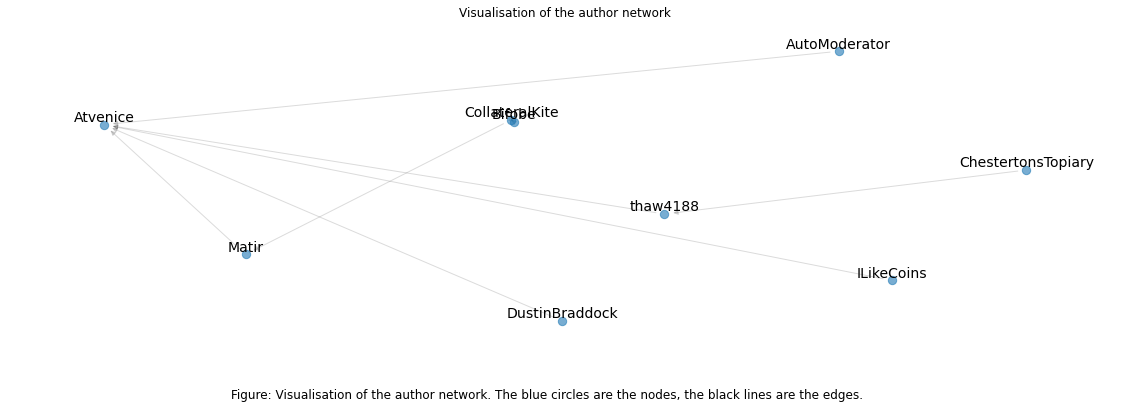

In [99]:
plt.figure(figsize=(20,6))  #set the figure
plt.title("Visualisation of the author network")
plt.axis('off')
nx.draw_networkx_nodes(authorGraph, positions_authors, node_size=70, alpha=0.6)#, node_color=color_map)
nx.draw_networkx_edges(authorGraph, positions_authors, alpha=0.14)#, edge_color=edge_map)
labels = nx.draw_networkx_labels(authorGraph, positions_authors,font_size = 14, verticalalignment="bottom")
_=plt.figtext(0.5, 0.01, "Figure: Visualisation of the author network. The blue circles are the nodes, the black lines are the edges.", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [100]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.002,

                        # Performance
                        jitterTolerance=0.2,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=3.0,
                        strongGravityMode=True,
                        gravity=0.15,

                        # Log
                        verbose=True)

positions_comments = forceatlas2.forceatlas2_networkx_layout(commentsGraph, pos=None, iterations=1000)  #prepare the visualisation: set the positions of the nodes



100%|██████████| 1000/1000 [00:00<00:00, 29238.79it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


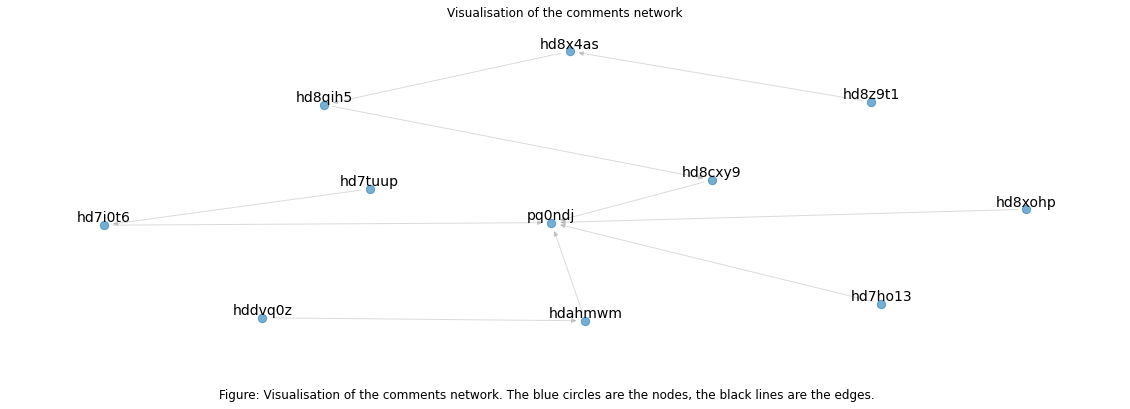

In [101]:
plt.figure(figsize=(20,6))  #set the figure
plt.title("Visualisation of the comments network")
plt.axis('off')
nx.draw_networkx_nodes(commentsGraph, positions_comments, node_size=70, alpha=0.6)#, node_color=color_map)
nx.draw_networkx_edges(commentsGraph, positions_comments, alpha=0.14)#, edge_color=edge_map)
labels = nx.draw_networkx_labels(commentsGraph, positions_comments,font_size = 14, verticalalignment="bottom")
_=plt.figtext(0.5, 0.01, "Figure: Visualisation of the comments network. The blue circles are the nodes, the black lines are the edges.", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()